### Step 0: To start ... 

In [313]:
# Turn on multi-threading on your computer for faster calculation 
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


# Steps 1 and 2: Install and load the necessary packages and libraries

In [314]:


import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")
from pathlib import Path # to interact with file system.

import numpy as np # for working with arrays.
import pandas as pd # for working with data frames (tables).
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from dmba import plotDecisionTree, classificationSummary, regressionSummary

%matplotlib inline 
import matplotlib.pylab as plt
%matplotlib inline

from pathlib import Path

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
#from mord import LogisticIT #If you're looking for ordinal multi-class (more than 2 levels)
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from sklearn.linear_model import LinearRegression

# Step 3: Load the data

In [315]:
#display all the columns
pd.set_option("display.max_columns", None)

In [316]:
df = pd.read_csv('RMCase.csv', header = 0) #, encoding = "ISO-8859-1")
df.head()

ID Program.Code  From.Grade  To.Grade Group.State  Is.Non.Annual.  Days  \
0  1           HS         4.0       4.0          CA             0.0   1.0   
1  2           HC         8.0       8.0          AZ             0.0   7.0   
2  3           HD         8.0       8.0          FL             0.0   3.0   
3  4           HN         9.0      12.0          VA             1.0   3.0   
4  5           HD         6.0       8.0          FL             0.0   6.0   

  Travel.Type Departure.Date Return.Date Deposit.Date Special.Pay  Tuition  \
0           A      1/14/2011   1/14/2011    8/30/2010         NaN    424.0   
1           A      1/14/2011   1/21/2011   11/15/2009          CP   2350.0   
2           A      1/15/2011   1/17/2011   10/15/2010         NaN   1181.0   
3           B      1/15/2011   1/17/2011     1/7/2011         NaN    376.0   
4           T      1/16/2011   1/21/2011    9/30/2010         NaN    865.0   

   FRP.Active  FRP.Cancelled  FRP.Take.up.percent.   Early.RPL Latest.RPL  \
0        25.0            3.0                 0.424   3/29/2010  8/12/2010   
1         9.0            9.0                 0.409  10/20/2009  8/10/2010   
2        17.0            6.0                 0.708   4/29/2010  8/16/2010   
3         0.0            0.0                 0.000         NaN        NaN   
4        40.0            8.0                 0.494   3/29/2010  8/12/2010   

   Cancelled.Pax  Total.Discount.Pax Initial.System.Date Poverty.Code  \
0            3.0                 4.0           3/26/2010            B   
1           11.0                 3.0           10/2/2009            C   
2            6.0                 3.0           1/28/2010            C   
3            1.0                 0.0          10/19/2010          NaN   
4            9.0                 8.0           3/23/2010            D   

                Region  CRM.Segment School.Type  Parent.Meeting.Flag  \
0  Southern California          4.0      PUBLIC                  1.0   
1                Other         10.0      PUBLIC                  1.0   
2                Other         10.0      PUBLIC                  1.0   
3                Other          7.0         CHD                  0.0   
4                Other         10.0      PUBLIC                  1.0   

  MDR.Low.Grade  MDR.High.Grade  Total.School.Enrollment Income.Level  \
0             K             5.0                    927.0            Q   
1             7             8.0                    850.0            A   
2             6             8.0                    955.0            O   
3           NaN             NaN                      NaN          NaN   
4             6             8.0                    720.0            C   

   EZ.Pay.Take.Up.Rate  School.Sponsor SPR.Product.Type SPR.New.Existing  \
0                0.170             1.0       CA History         EXISTING   
1                0.091             0.0       East Coast         EXISTING   
2                0.042             0.0       East Coast         EXISTING   
3                0.000             0.0       East Coast         EXISTING   
4                0.383             0.0       East Coast         EXISTING   

    FPP  Total.Pax  SPR.Group.Revenue  NumberOfMeetingswithParents  \
0  59.0       63.0              424.0                          1.0   
1  22.0       25.0             2350.0                          2.0   
2  24.0       27.0             1181.0                          1.0   
3  18.0       18.0              376.0                          0.0   
4  81.0       89.0              865.0                          1.0   

  FirstMeeting LastMeeting  DifferenceTraveltoFirstMeeting  \
0    8/12/2010   8/12/2010                           155.0   
1   11/17/2009   8/27/2010                           423.0   
2    9/13/2010   9/13/2010                           124.0   
3          NaN         NaN                             NaN   
4    8/24/2010   8/24/2010                           145.0   

   DifferenceTraveltoLastMeeting SchoolGradeT

# Step 4: "Cleaning" the data

In this case the data are purposefully left slightly "dirty", that is, they are pre-cleaned somewhat, but for learning purposes some elements of dirty data still remain: 

1. Some datafields (variables, features, columns) have incorrect types -- they should be converted, for instance, from numbers to categoricals 
    
2. Some categorical variables have too many categories (levels), and some of the levels are too rare: for instance, there is only one group from Bahamas (why is this a problem?) -- such data should be merged into more populous category
    
3. Some data are missing and we need to replace or impute them 

To conclude data cleaning we will, of course, have to create dummy variables for the categorical variables
 

In [317]:
df.info() # Checking what kinds of data we have 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              2390 non-null   object 
 1   Program.Code                    2389 non-null   object 
 2   From.Grade                      2262 non-null   float64
 3   To.Grade                        2239 non-null   float64
 4   Group.State                     2389 non-null   object 
 5   Is.Non.Annual.                  2389 non-null   float64
 6   Days                            2389 non-null   float64
 7   Travel.Type                     2389 non-null   object 
 8   Departure.Date                  2389 non-null   object 
 9   Return.Date                     2389 non-null   object 
 10  Deposit.Date                    2389 non-null   object 
 11  Special.Pay                     470 non-null    object 
 12  Tuition                         23

In [318]:
df['From.Grade'] = ['Elementary' if grade in[3,4,5] else grade for grade in df['From.Grade']]
df['From.Grade'] = ['Middle' if grade in[6,7,8] else grade for grade in df['From.Grade']]
df['From.Grade'] = ['High' if grade in[9,10,11,12] else grade for grade in df['From.Grade']]
df['To.Grade'] = ['Elementary' if grade in[3,4,5] else grade for grade in df['To.Grade']]
df['To.Grade'] = ['Middle' if grade in[6,7,8] else grade for grade in df['To.Grade']]
df['To.Grade'] = ['High' if grade in[9,10,11,12] else grade for grade in df['To.Grade']]

df.head()


ID Program.Code  From.Grade    To.Grade Group.State  Is.Non.Annual.  Days  \
0  1           HS  Elementary  Elementary          CA             0.0   1.0   
1  2           HC      Middle      Middle          AZ             0.0   7.0   
2  3           HD      Middle      Middle          FL             0.0   3.0   
3  4           HN        High        High          VA             1.0   3.0   
4  5           HD      Middle      Middle          FL             0.0   6.0   

  Travel.Type Departure.Date Return.Date Deposit.Date Special.Pay  Tuition  \
0           A      1/14/2011   1/14/2011    8/30/2010         NaN    424.0   
1           A      1/14/2011   1/21/2011   11/15/2009          CP   2350.0   
2           A      1/15/2011   1/17/2011   10/15/2010         NaN   1181.0   
3           B      1/15/2011   1/17/2011     1/7/2011         NaN    376.0   
4           T      1/16/2011   1/21/2011    9/30/2010         NaN    865.0   

   FRP.Active  FRP.Cancelled  FRP.Take.up.percent.   Early.RPL Latest.RPL  \
0        25.0            3.0                 0.424   3/29/2010  8/12/2010   
1         9.0            9.0                 0.409  10/20/2009  8/10/2010   
2        17.0            6.0                 0.708   4/29/2010  8/16/2010   
3         0.0            0.0                 0.000         NaN        NaN   
4        40.0            8.0                 0.494   3/29/2010  8/12/2010   

   Cancelled.Pax  Total.Discount.Pax Initial.System.Date Poverty.Code  \
0            3.0                 4.0           3/26/2010            B   
1           11.0                 3.0           10/2/2009            C   
2            6.0                 3.0           1/28/2010            C   
3            1.0                 0.0          10/19/2010          NaN   
4            9.0                 8.0           3/23/2010            D   

                Region  CRM.Segment School.Type  Parent.Meeting.Flag  \
0  Southern California          4.0      PUBLIC                  1.0   
1                Other         10.0      PUBLIC                  1.0   
2                Other         10.0      PUBLIC                  1.0   
3                Other          7.0         CHD                  0.0   
4                Other         10.0      PUBLIC                  1.0   

  MDR.Low.Grade  MDR.High.Grade  Total.School.Enrollment Income.Level  \
0             K             5.0                    927.0            Q   
1             7             8.0                    850.0            A   
2             6             8.0                    955.0            O   
3           NaN             NaN                      NaN          NaN   
4             6             8.0                    720.0            C   

   EZ.Pay.Take.Up.Rate  School.Sponsor SPR.Product.Type SPR.New.Existing  \
0                0.170             1.0       CA History         EXISTING   
1                0.091             0.0       East Coast         EXISTING   
2                0.042             0.0       East Coast         EXISTING   
3                0.000             0.0       East Coast         EXISTING   
4                0.383             0.0       East Coast         EXISTING   

    FPP  Total.Pax  SPR.Group.Revenue  NumberOfMeetingswithParents  \
0  59.0       63.0              424.0                          1.0   
1  22.0       25.0             2350.0                          2.0   
2  24.0       27.0             1181.0                          1.0   
3  18.0       18.0              376.0                          0.0   
4  81.0       89.0              865.0                          1.0   

  FirstMeeting LastMeeting  DifferenceTraveltoFirstMeeting  \
0    8/12/2010   8/12/2010                           155.0   
1   11/17/2009   8/27/2010                           423.0   
2    9/13/2010   9/13/2010                           124.0   
3          NaN         NaN                             NaN   
4    8/24/2010   8/24/2010                           145.0   

   DifferenceTraveltoLastMeeting 

In [319]:
df['Days'] = ['short_length' if days in[1,2,3,4] else days for days in df['Days']]
df['Days'] = ['middle_length' if days in[5,6,7,8] else days for days in df['Days']]
df['Days'] = ['long_length' if days in[9,10,11,12] else days for days in df['Days']]
df['Days'] = ['Missing' if days in[0] else days for days in df['Days']]
df.head()

ID Program.Code  From.Grade    To.Grade Group.State  Is.Non.Annual.  \
0  1           HS  Elementary  Elementary          CA             0.0   
1  2           HC      Middle      Middle          AZ             0.0   
2  3           HD      Middle      Middle          FL             0.0   
3  4           HN        High        High          VA             1.0   
4  5           HD      Middle      Middle          FL             0.0   

            Days Travel.Type Departure.Date Return.Date Deposit.Date  \
0   short_length           A      1/14/2011   1/14/2011    8/30/2010   
1  middle_length           A      1/14/2011   1/21/2011   11/15/2009   
2   short_length           A      1/15/2011   1/17/2011   10/15/2010   
3   short_length           B      1/15/2011   1/17/2011     1/7/2011   
4  middle_length           T      1/16/2011   1/21/2011    9/30/2010   

  Special.Pay  Tuition  FRP.Active  FRP.Cancelled  FRP.Take.up.percent.  \
0         NaN    424.0        25.0            3.0                 0.424   
1          CP   2350.0         9.0            9.0                 0.409   
2         NaN   1181.0        17.0            6.0                 0.708   
3         NaN    376.0         0.0            0.0                 0.000   
4         NaN    865.0        40.0            8.0                 0.494   

    Early.RPL Latest.RPL  Cancelled.Pax  Total.Discount.Pax  \
0   3/29/2010  8/12/2010            3.0                 4.0   
1  10/20/2009  8/10/2010           11.0                 3.0   
2   4/29/2010  8/16/2010            6.0                 3.0   
3         NaN        NaN            1.0                 0.0   
4   3/29/2010  8/12/2010            9.0                 8.0   

  Initial.System.Date Poverty.Code               Region  CRM.Segment  \
0           3/26/2010            B  Southern California          4.0   
1           10/2/2009            C                Other         10.0   
2           1/28/2010            C                Other         10.0   
3          10/19/2010          NaN                Other          7.0   
4           3/23/2010            D                Other         10.0   

  School.Type  Parent.Meeting.Flag MDR.Low.Grade  MDR.High.Grade  \
0      PUBLIC                  1.0             K             5.0   
1      PUBLIC                  1.0             7             8.0   
2      PUBLIC                  1.0             6             8.0   
3         CHD                  0.0           NaN             NaN   
4      PUBLIC                  1.0             6             8.0   

   Total.School.Enrollment Income.Level  EZ.Pay.Take.Up.Rate  School.Sponsor  \
0                    927.0            Q                0.170             1.0   
1                    850.0            A                0.091             0.0   
2                    955.0            O                0.042             0.0   
3                      NaN          NaN                0.000             0.0   
4                    720.0            C                0.383             0.0   

  SPR.Product.Type SPR.New.Existing   FPP  Total.Pax  SPR.Group.Revenue  \
0       CA History         EXISTING  59.0       63.0              424.0   
1       East Coast         EXISTING  22.0       25.0             2350.0   
2       East Coast         EXISTING  24.0       27.0             1181.0   
3       East Coast         EXISTING  18.0       18.0              376.0   
4       East Coast         EXISTING  81.0       89.0              865.0   

   NumberOfMeetingswithParents FirstMeeting LastMeeting  \
0                          1.0    8/12/2010   8/12/2010   
1                          2.0   11/17/2009   8/27/2010   
2                          1.0    9/13/2010   9/13/2010   
3                          0.0          NaN         NaN   
4                          1.0    8/24/2010   8/24/2010   

   DifferenceTraveltoFirstMeeting  DifferenceTraveltoLastMeeting  \
0                           155.0                          155.0   
1                           423.0  

In [320]:
df['Group.State'].unique()

array(['CA', 'AZ', 'FL', 'VA', 'LA', 'MA', 'MX', 'TX', 'IA', 'MI', 'NY',
       'NC', 'OH', 'MN', 'AR', 'IL', 'IN', 'WI', 'MO', 'ID', 'TN', 'KS',
       'AL', 'MS', 'KY', 'OR', 'NE', 'CO', 'SC', 'NM', 'HI', 'OK', 'AK',
       'GA', 'NJ', 'WA', 'NV', 'RI', 'MT', 'CT', 'Cayman Islands', 'PR',
       'UT', 'PA', 'ME', 'MD', 'VT', 'NH', 'AB', 'Bermuda', 'WV', 'SD',
       'ND', 'WY', nan], dtype=object)

In [321]:
df['Group.State'] = ['NorthEast' if state in['ME','VT','NH','MA','CT','RI','NY','PA','NJ'] else state for state in df['Group.State']]
df['Group.State'] = ['MidWest' if state in['ND','SD','NE','KS','MN','IA','MO','WI','IL','MI','IN','OH'] else state for state in df['Group.State']]
df['Group.State'] = ['South' if state in['DE','FL','SC','NC','TN','KY','WV','VA','MD','TX','LA','OK','AR','MS','AL','GA'] else state for state in df['Group.State']]
df['Group.State'] = ['West' if state in['AZ','CO','ID','MT','NV','NM','UT','WY','AK','CA','HI','OR','WA'] else state for state in df['Group.State']]
df['Group.State'] = ['Missing' if state not in['NorthEast','MidWest','South','West'] else state for state in df['Group.State']]

df.head()

ID Program.Code  From.Grade    To.Grade Group.State  Is.Non.Annual.  \
0  1           HS  Elementary  Elementary        West             0.0   
1  2           HC      Middle      Middle        West             0.0   
2  3           HD      Middle      Middle       South             0.0   
3  4           HN        High        High       South             1.0   
4  5           HD      Middle      Middle       South             0.0   

            Days Travel.Type Departure.Date Return.Date Deposit.Date  \
0   short_length           A      1/14/2011   1/14/2011    8/30/2010   
1  middle_length           A      1/14/2011   1/21/2011   11/15/2009   
2   short_length           A      1/15/2011   1/17/2011   10/15/2010   
3   short_length           B      1/15/2011   1/17/2011     1/7/2011   
4  middle_length           T      1/16/2011   1/21/2011    9/30/2010   

  Special.Pay  Tuition  FRP.Active  FRP.Cancelled  FRP.Take.up.percent.  \
0         NaN    424.0        25.0            3.0                 0.424   
1          CP   2350.0         9.0            9.0                 0.409   
2         NaN   1181.0        17.0            6.0                 0.708   
3         NaN    376.0         0.0            0.0                 0.000   
4         NaN    865.0        40.0            8.0                 0.494   

    Early.RPL Latest.RPL  Cancelled.Pax  Total.Discount.Pax  \
0   3/29/2010  8/12/2010            3.0                 4.0   
1  10/20/2009  8/10/2010           11.0                 3.0   
2   4/29/2010  8/16/2010            6.0                 3.0   
3         NaN        NaN            1.0                 0.0   
4   3/29/2010  8/12/2010            9.0                 8.0   

  Initial.System.Date Poverty.Code               Region  CRM.Segment  \
0           3/26/2010            B  Southern California          4.0   
1           10/2/2009            C                Other         10.0   
2           1/28/2010            C                Other         10.0   
3          10/19/2010          NaN                Other          7.0   
4           3/23/2010            D                Other         10.0   

  School.Type  Parent.Meeting.Flag MDR.Low.Grade  MDR.High.Grade  \
0      PUBLIC                  1.0             K             5.0   
1      PUBLIC                  1.0             7             8.0   
2      PUBLIC                  1.0             6             8.0   
3         CHD                  0.0           NaN             NaN   
4      PUBLIC                  1.0             6             8.0   

   Total.School.Enrollment Income.Level  EZ.Pay.Take.Up.Rate  School.Sponsor  \
0                    927.0            Q                0.170             1.0   
1                    850.0            A                0.091             0.0   
2                    955.0            O                0.042             0.0   
3                      NaN          NaN                0.000             0.0   
4                    720.0            C                0.383             0.0   

  SPR.Product.Type SPR.New.Existing   FPP  Total.Pax  SPR.Group.Revenue  \
0       CA History         EXISTING  59.0       63.0              424.0   
1       East Coast         EXISTING  22.0       25.0             2350.0   
2       East Coast         EXISTING  24.0       27.0             1181.0   
3       East Coast         EXISTING  18.0       18.0              376.0   
4       East Coast         EXISTING  81.0       89.0              865.0   

   NumberOfMeetingswithParents FirstMeeting LastMeeting  \
0                          1.0    8/12/2010   8/12/2010   
1                          2.0   11/17/2009   8/27/2010   
2                          1.0    9/13/2010   9/13/2010   
3                          0.0          NaN         NaN   
4                          1.0    8/24/2010   8/24/2010   

   DifferenceTraveltoFirstMeeting  DifferenceTraveltoLastMeeting  \
0                           155.0                          155.0   
1                           423.0  

In [322]:
df['Group.State'].unique()

array(['West', 'South', 'NorthEast', 'Missing', 'MidWest'], dtype=object)

In [323]:
possible_cvar=['Program.Code', 'From.Grade', 'To.Grade', 'Group.State',
       'Is.Non.Annual.', 'Days', 'Travel.Type', 
        'Region','School.Type',
       'Parent.Meeting.Flag', 
        'Income.Level', 
       'School.Sponsor', 'SPR.Product.Type', 'SPR.New.Existing', 
       'NumberOfMeetingswithParents']
# "Cleaning" the data -- part 1: converting data types that should be categorical into "category"

df['From.Grade'] = df['From.Grade'].astype('category')
df['To.Grade'] = df['To.Grade'].astype('category')
df['Is.Non.Annual.'] = df['Is.Non.Annual.'].astype('category')
df['Parent.Meeting.Flag'] = df['Parent.Meeting.Flag'].astype('category')
df['Days'] = df['Days'].astype('category')
df['CRM.Segment'] = df['CRM.Segment'].astype('category')
df['MDR.High.Grade'] = df['MDR.High.Grade'].astype('category')
df['School.Sponsor'] = df['School.Sponsor'].astype('category')
#df['NumberOfMeetingswithParents'] = df['NumberOfMeetingswithParents'].astype('category')
df['SingleGradeTripFlag'] = df['SingleGradeTripFlag'].astype('category')
df['Travel.Type'] = df['Travel.Type'].astype('category')
df['SPR.New.Existing'] = df['SPR.New.Existing'].astype('category')
df['Income.Level'] = df['Income.Level'].astype('category')
df['School.Sponsor'] = df['School.Sponsor'].astype('category')
df['Region'] = df['Region'].astype('category')
df['School.Type'] = df['School.Type'].astype('category')
df.info() # let's check the result

#I only converted some variables which I thought would be useful. If you feel other variables that may be useful have their types incorrect, 
#please convert them too!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              2390 non-null   object  
 1   Program.Code                    2389 non-null   object  
 2   From.Grade                      2262 non-null   category
 3   To.Grade                        2239 non-null   category
 4   Group.State                     2392 non-null   object  
 5   Is.Non.Annual.                  2389 non-null   category
 6   Days                            2389 non-null   category
 7   Travel.Type                     2389 non-null   category
 8   Departure.Date                  2389 non-null   object  
 9   Return.Date                     2389 non-null   object  
 10  Deposit.Date                    2389 non-null   object  
 11  Special.Pay                     470 non-null    object  
 12  Tuition             

In [324]:
# "Cleaning" the data -- part 2: replacing/imputing missing data

pd.DataFrame(df).isna().sum() # Lets check if we have any missing data -- the result shows that yes, and a lot

ID                                   2
Program.Code                         3
From.Grade                         130
To.Grade                           153
Group.State                          0
Is.Non.Annual.                       3
Days                                 3
Travel.Type                          3
Departure.Date                       3
Return.Date                          3
Deposit.Date                         3
Special.Pay                       1922
Tuition                              3
FRP.Active                           3
FRP.Cancelled                        3
FRP.Take.up.percent.                 3
Early.RPL                          676
Latest.RPL                          22
Cancelled.Pax                        3
Total.Discount.Pax                   3
Initial.System.Date                 11
Poverty.Code                       602
Region                               3
CRM.Segment                          7
School.Type                          3
Parent.Meeting.Flag      

In [325]:
# "Cleaning" the data -- part 2: replacing/imputing missing data

# Approach:
# If a categorical feature is missing: add new category 'missing_value' 
# For Numerical features: replacing with 0 (or median, mean, or most frequent value, etc.) An alternative approach is to imputate, see here: https://scikit-learn.org/stable/modules/impute.html 

# fixing categoricals
imputer = SimpleImputer(missing_values = np.nan, strategy='constant',fill_value="Missing")
imputer.fit(df.select_dtypes(exclude=['int64','float64']))
df[df.select_dtypes(exclude=['int64','float64']).columns] = imputer.transform(df.select_dtypes(exclude=['int64','float64']))
           
# fixing numericals 
imputer = SimpleImputer(missing_values = np.nan, strategy='constant', fill_value=0)
imputer.fit(df.select_dtypes(include=['int64','float64']))
df[df.select_dtypes(include=['int64','float64']).columns] = imputer.transform(df.select_dtypes(include=['int64','float64']))

# Lets examine the result, e.g., datafield "Poverty.Code"
df[['Poverty.Code']]


Poverty.Code
0               B
1               C
2               C
3         Missing
4               D
...           ...
2387      Missing
2388            B
2389      Missing
2390      Missing
2391      Missing

[2392 rows x 1 columns]

In [326]:
df['Days'].unique()

array(['short_length', 'middle_length', 'long_length', 'Missing'],
      dtype=object)

In [327]:
# "Cleaning" the data -- part 3: combining rare categories ("levels")

df['Group.State'].value_counts() # To get the intuition lets examine the column Group.State

# Here is the code to check all columns, in case you're interested
# for col in df.select_dtypes(include=['category','object','bool']).columns:
#    print(col)
#    print(df[col].value_counts())
#    print('\n') 


West         1143
South         610
MidWest       530
NorthEast      99
Missing        10
Name: Group.State, dtype: int64

In [328]:
# "Cleaning" the data -- part 3: combining rare categories ("levels")

# Here is a custom function that we will call CombineRareCategories
# this function has two arguments: the name of the dataframe (data) and the minimal number of datapoints to remain a separate category (mincount)
# this function will loop through all the columns in the dataframe, and will combine all categories that appear in the data les than mincount number of times into (Other)

def CombineRareCategories(data, mincount):
    for col in data.columns:
        if (type(data[col][0]) == str):
            for index, row in pd.DataFrame(data[col].value_counts()).iterrows():
                if ( row[0] < mincount):
                    df[col].replace(index, 'Other_' + col, inplace = True)
                else:
                    None

# lets apply this function to our data with mincount=20. You can try lowering this cut-off too!                    
CombineRareCategories(df, 20)        

df[0:10] #lets check the result

ID        Program.Code  From.Grade    To.Grade        Group.State  \
0  Other_ID                  HS  Elementary  Elementary               West   
1  Other_ID                  HC      Middle      Middle               West   
2  Other_ID                  HD      Middle      Middle              South   
3  Other_ID                  HN        High        High              South   
4  Other_ID                  HD      Middle      Middle              South   
5  Other_ID                  HC        High        High              South   
6  Other_ID                  SG        High        High          NorthEast   
7  Other_ID  Other_Program.Code        High        High  Other_Group.State   
8  Other_ID  Other_Program.Code      Middle      Middle               West   
9  Other_ID                  HD      Middle      Middle              South   

  Is.Non.Annual.           Days        Travel.Type        Departure.Date  \
0            0.0   short_length                  A  Other_Departure.Date   
1            0.0  middle_length                  A  Other_Departure.Date   
2            0.0   short_length                  A  Other_Departure.Date   
3            1.0   short_length                  B  Other_Departure.Date   
4            0.0  middle_length  Other_Travel.Type  Other_Departure.Date   
5            0.0   short_length                  A  Other_Departure.Date   
6            1.0  middle_length                  A  Other_Departure.Date   
7            0.0  middle_length                  A  Other_Departure.Date   
8            0.0  middle_length                  A  Other_Departure.Date   
9            0.0   short_length                  A  Other_Departure.Date   

         Return.Date        Deposit.Date Special.Pay  Tuition  FRP.Active  \
0  Other_Return.Date  Other_Deposit.Date     Missing    424.0        25.0   
1  Other_Return.Date  Other_Deposit.Date          CP   2350.0         9.0   
2  Other_Return.Date          10/15/2010     Missing   1181.0        17.0   
3  Other_Return.Date  Other_Deposit.Date     Missing    376.0         0.0   
4  Other_Return.Date           9/30/2010     Missing    865.0        40.0   
5  Other_Return.Date           9/30/2010     Missing   2025.0         9.0   
6  Other_Return.Date          10/15/2010     Missing   1977.0        16.0   
7  Other_Return.Date           10/1/2010     Missing   3379.0        10.0   
8  Other_Return.Date            6/1/2010          CP   2200.0        30.0   
9  Other_Return.Date          10/25/2010     Missing   1428.0        51.0   

   FRP.Cancelled  FRP.Take.up.percent.        Early.RPL        Latest.RPL  \
0            3.0                 0.424        3/29/2010         8/12/2010   
1            9.0                 0.409  Other_Early.RPL         8/10/2010   
2            6.0                 0.708        4/29/2010         8/16/2010   
3            0.0                 0.000          Missing           Missing   
4            8.0                 0.494        3/29/2010         8/12/2010   
5            4.0                 0.900  Other_Early.RPL  Other_Latest.RPL   
6            4.0                 0.640        2/25/2010          9/1/2010   
7            0.0                 0.769  Other_Early.RPL         8/23/2010   
8            0.0                 0.577  Other_Early.RPL  Other_Latest.RPL   
9            1.0                 0.773         4/1/2010         8/11/2010   

   Cancelled.Pax  Total.Discount.Pax        Initial.System.Date Poverty.Code  \
0            3.0                 4.0                  3/26/2010            B   
1           11.0                 3.0  Other_Initial.System.Date            C   
2            6.0                 3.0                  1/28/2010            C   
3            1.0                 0.0  Other_Initial.System.Date      Missing   
4            9.0                 8.0  Other_Initial.System.Date            D   
5            3.0                 1.0  Other_Initial.System.Date            C   
6            5.0                 2.0                  2/2

In [329]:
# The data is now ready to analyze for you (Make sure you create dummies though!)
df.describe()

Tuition   FRP.Active  FRP.Cancelled  FRP.Take.up.percent.  \
count  2392.000000  2392.000000    2392.000000           2392.000000   
mean   1613.191890    16.846572       3.301421              0.570028   
std     647.221829    16.942675       3.676577              0.231405   
min       0.000000     0.000000       0.000000              0.000000   
25%    1173.750000     6.000000       1.000000              0.455000   
50%    1699.000000    12.000000       2.000000              0.600000   
75%    2047.250000    23.000000       4.000000              0.727000   
max    4200.000000   257.000000      45.000000              1.000000   

       Cancelled.Pax  Total.Discount.Pax  Total.School.Enrollment  \
count    2392.000000         2392.000000              2392.000000   
mean        4.801421            2.949833               622.879599   
std         4.661376            2.876518               422.767279   
min         0.000000            0.000000                 0.000000   
25%         2.000000            1.000000               336.750000   
50%         4.000000            2.000000               575.000000   
75%         6.000000            4.000000               811.000000   
max        39.000000           47.000000              3990.000000   

       EZ.Pay.Take.Up.Rate          FPP    Total.Pax  SPR.Group.Revenue  \
count          2392.000000  2392.000000  2392.000000        2392.000000   
mean              0.207682    31.257943    34.207776        1613.191890   
std               0.155730    29.134295    31.593546         647.221829   
min               0.000000     0.000000     0.000000           0.000000   
25%               0.100000    12.000000    14.000000        1173.750000   
50%               0.198000    23.000000    26.000000        1699.000000   
75%               0.292000    41.000000    44.000000        2047.250000   
max               1.750000   286.000000   313.000000        4200.000000   

       NumberOfMeetingswithParents  DifferenceTraveltoFirstMeeting  \
count                  2392.000000                     2392.000000   
mean                      1.100753                      224.831104   
std                       0.612404                      117.487616   
min                       0.000000                     -204.000000   
25%                       1.000000                      187.000000   
50%                       1.000000                      238.000000   
75%                       1.000000                      277.000000   
max                       2.000000                      749.000000   

       DifferenceTraveltoLastMeeting  FPP.to.School.enrollment   FPP.to.PAX  \
count                    2392.000000               2392.000000  2392.000000   
mean                      196.431020                  0.063583     0.899537   
std                        94.147025                  0.080535     0.058533   
min                      -204.000000                  0.000000     0.000000   
25%                       179.000000                  0.018352     0.882353   
50%                       220.000000                  0.043333     0.909091   
75%                       258.000000                  0.085727     0.933333   
max                       749.000000                  2.052632     1.000000   

       Num.of.Non_FPP.PAX  Retained.in.2012.  
count         2392.000000        2392.000000  
mean             2.949833           0.606605  
std              2.876518           0.488605  
min              0.000000           0.000000  
25%              1.000000           0.000000  
50%              2.000000           1.000000  
75%              4.000000           1.000000  
max             47.000000           1.000000

In [330]:
df.columns

Index(['ID', 'Program.Code', 'From.Grade', 'To.Grade', 'Group.State',
       'Is.Non.Annual.', 'Days', 'Travel.Type', 'Departure.Date',
       'Return.Date', 'Deposit.Date', 'Special.Pay', 'Tuition', 'FRP.Active',
       'FRP.Cancelled', 'FRP.Take.up.percent.', 'Early.RPL', 'Latest.RPL',
       'Cancelled.Pax', 'Total.Discount.Pax', 'Initial.System.Date',
       'Poverty.Code', 'Region', 'CRM.Segment', 'School.Type',
       'Parent.Meeting.Flag', 'MDR.Low.Grade', 'MDR.High.Grade',
       'Total.School.Enrollment', 'Income.Level', 'EZ.Pay.Take.Up.Rate',
       'School.Sponsor', 'SPR.Product.Type', 'SPR.New.Existing', 'FPP',
       'Total.Pax', 'SPR.Group.Revenue', 'NumberOfMeetingswithParents',
       'FirstMeeting', 'LastMeeting', 'DifferenceTraveltoFirstMeeting',
       'DifferenceTraveltoLastMeeting', 'SchoolGradeTypeLow',
       'SchoolGradeTypeHigh', 'SchoolGradeType', 'DepartureMonth',
       'GroupGradeTypeLow', 'GroupGradeTypeHigh', 'GroupGradeType',
       'MajorProgramCode', '

# Exploratory data analysis

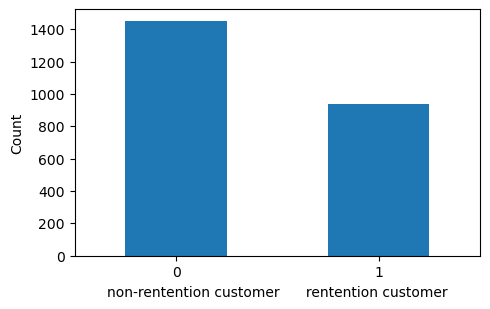

In [331]:
#bar chart for rentenion customer vs non-rentenion customer 
ax=df['Retained.in.2012.'].value_counts().plot(kind='bar',figsize=[5, 3])
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
plt.tight_layout()
ax.set_xlabel('non-rentention customer      rentention customer')
plt.show()

In [332]:
#explore 'Retained.in.2012.' and Days

In [333]:
# retention rate in each days type group
df.groupby('Days').mean()['Retained.in.2012.']

Days
Other_Days       0.000000
long_length      0.363636
middle_length    0.590426
short_length     0.633682
Name: Retained.in.2012., dtype: float64

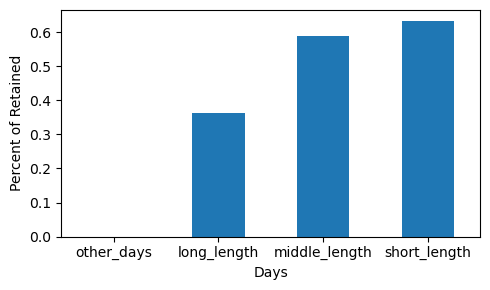

In [334]:
ax = df.groupby('Days').mean()['Retained.in.2012.'].plot(kind='bar', figsize=[5, 3])
ax.set_ylabel('Percent of Retained')
#ax.set_xticklabels(ax.get_xticks(), rotation = 0)
ax.set_xticklabels(['other_days','long_length','middle_length','short_length'],rotation = 0)
plt.tight_layout()
plt.show()

In [335]:
df.groupby('Income.Level').mean()['Retained.in.2012.']

Income.Level
A                     0.500000
B                     0.484848
C                     0.462687
D                     0.512195
E                     0.450000
F                     0.485714
G                     0.505495
H                     0.529412
I                     0.597484
J                     0.493750
K                     0.601626
L                     0.607477
M                     0.666667
Missing               0.507692
N                     0.574324
O                     0.665414
Other_Income.Level    0.857143
P                     0.773585
Q                     0.717314
Z                     0.522727
Name: Retained.in.2012., dtype: float64

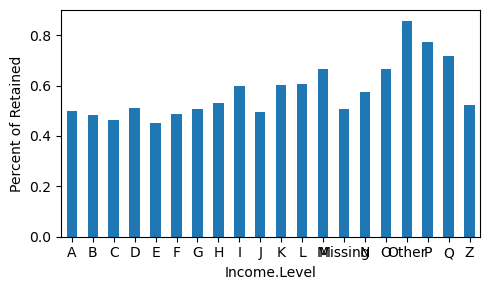

In [336]:
ax = df.groupby('Income.Level').mean()['Retained.in.2012.'].plot(kind='bar', figsize=[5, 3])
ax.set_ylabel('Percent of Retained')
ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J','K','L','M','Missing','N','O','Other','P','Q','Z'], rotation = 0)
plt.tight_layout()
plt.show()

In [337]:
#explore the relation between  Existing or New customer and retenion 
df.groupby('SPR.New.Existing').mean()['Retained.in.2012.']

SPR.New.Existing
EXISTING                  0.733043
NEW                       0.349105
Other_SPR.New.Existing    0.000000
Name: Retained.in.2012., dtype: float64

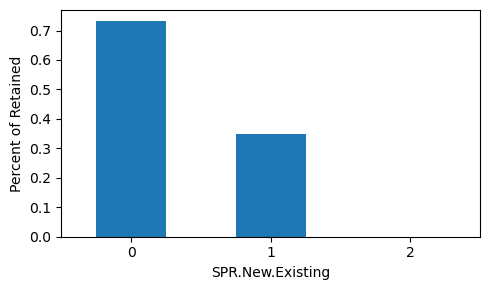

In [338]:
ax = df.groupby('SPR.New.Existing').mean()['Retained.in.2012.'].plot(kind='bar', figsize=[5, 3])
ax.set_ylabel('Percent of Retained')
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
plt.tight_layout()
plt.show()

In [339]:
#explore the relation between  parent.Meeting and retenion 
df.groupby('Parent.Meeting.Flag').mean()['Retained.in.2012.']

Parent.Meeting.Flag
0.0        0.632047
1.0        0.603314
Missing    0.000000
Name: Retained.in.2012., dtype: float64

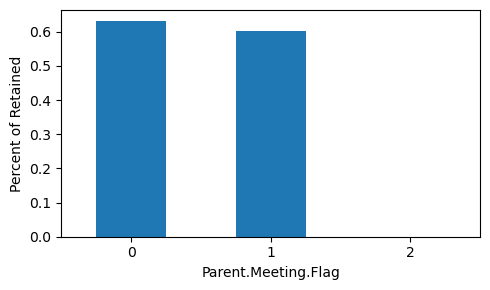

In [340]:
ax = df.groupby('Parent.Meeting.Flag').mean()['Retained.in.2012.'].plot(kind='bar', figsize=[5, 3])
ax.set_ylabel('Percent of Retained')
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
plt.tight_layout()
plt.show()

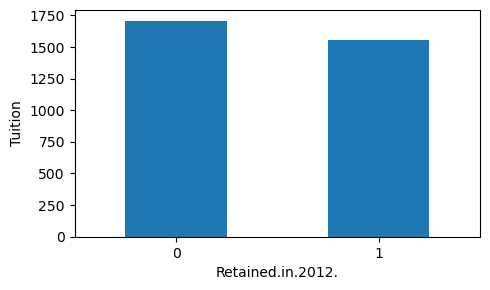

In [341]:
#explore the relation between tuition and retenion customer
ax = df.groupby('Retained.in.2012.').mean().Tuition.plot(kind='bar', figsize=[5, 3])
ax.set_ylabel('Tuition')
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
plt.tight_layout()
plt.show()

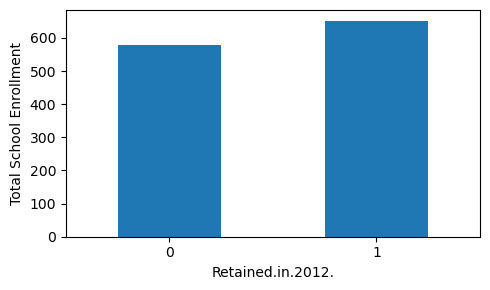

In [342]:
#explore the relation between Total School Enrollment and retenion customer
ax = df.groupby('Retained.in.2012.').mean()['Total.School.Enrollment'].plot(kind='bar', figsize=[5, 3])
ax.set_ylabel('Total School Enrollment')
ax.set_xticklabels(ax.get_xticks(), rotation = 0)

plt.tight_layout()
plt.show()

In [343]:
#explore the relation between group state and retenion customer
df.groupby('Group.State').mean()['Retained.in.2012.']


Group.State
MidWest              0.652830
NorthEast            0.656566
Other_Group.State    0.300000
South                0.577049
West                 0.599300
Name: Retained.in.2012., dtype: float64

In [344]:
df.groupby('Travel.Type').mean()['Retained.in.2012.']

Travel.Type
A                    0.592354
B                    0.692098
Other_Travel.Type    0.363636
Name: Retained.in.2012., dtype: float64

# 1st KNN Model

In [345]:
var = ['From.Grade', 'To.Grade', 'Group.State','Is.Non.Annual.', 'Days','Travel.Type',
  'Parent.Meeting.Flag','School.Sponsor', 'Income.Level', 
       'SingleGradeTripFlag', 'SPR.Product.Type',
       'SPR.New.Existing','Retained.in.2012.' ]

In [346]:
#Partition the data into train and valid.
train_df, valid_df = train_test_split(df, test_size=0.4, random_state=1)
train_df.head()

ID        Program.Code From.Grade To.Grade Group.State  \
2211  Other_ID                  HD     Middle   Middle        West   
233   Other_ID                 HVP     Middle   Middle     MidWest   
1987  Other_ID                  HD     Middle   Middle        West   
1682  Other_ID  Other_Program.Code     Middle   Middle       South   
1646  Other_ID                  HD     Middle   Middle        West   

     Is.Non.Annual.           Days Travel.Type        Departure.Date  \
2211            0.0  middle_length           A             6/19/2011   
233             0.0  middle_length           B  Other_Departure.Date   
1987            0.0  middle_length           A             6/12/2011   
1682            0.0   short_length           A              6/6/2011   
1646            0.0  middle_length           A              6/5/2011   

            Return.Date Deposit.Date Special.Pay  Tuition  FRP.Active  \
2211          6/23/2011   10/15/2010     Missing   2120.0         5.0   
233   Other_Return.Date   10/30/2010     Missing    460.0        27.0   
1987          6/16/2011    10/1/2010     Missing   2060.0        15.0   
1682           6/9/2011   10/29/2010     Missing   2123.0         8.0   
1646           6/9/2011   10/22/2010     Missing   1797.0        11.0   

      FRP.Cancelled  FRP.Take.up.percent.        Early.RPL Latest.RPL  \
2211            3.0                 0.833          Missing  8/31/2010   
233             8.0                 0.551  Other_Early.RPL   9/1/2010   
1987           10.0                 0.556  Other_Early.RPL  8/27/2010   
1682            1.0                 0.571  Other_Early.RPL  8/23/2010   
1646            2.0                 0.579  Other_Early.RPL  8/24/2010   

      Cancelled.Pax  Total.Discount.Pax        Initial.System.Date  \
2211            4.0                 2.0  Other_Initial.System.Date   
233             8.0                 3.0                   3/6/2010   
1987           12.0                 4.0                  1/22/2010   
1682            5.0                 2.0                  2/27/2010   
1646            2.0                 2.0  Other_Initial.System.Date   

     Poverty.Code               Region CRM.Segment School.Type  \
2211            B  Northern California         5.0      PUBLIC   
233             C                Other        10.0      PUBLIC   
1987            B  Northern California        10.0      PUBLIC   
1682            C               Dallas        10.0      PUBLIC   
1646            B  Northern California         5.0      PUBLIC   

     Parent.Meeting.Flag MDR.Low.Grade MDR.High.Grade  \
2211                 0.0             7            8.0   
233                  1.0             5            8.0   
1987                 1.0             6            8.0   
1682                 1.0             6            8.0   
1646                 1.0            PK            8.0   

      Total.School.Enrollment Income.Level  EZ.Pay.Take.Up.Rate  \
2211                    800.0            Q                0.333   
233                     423.0            I                0.143   
1987                    700.0            N                0.259   
1682                    765.0            M                0.429   
1646                    650.0            J                0.000   

     School.Sponsor SPR.Product.Type SPR.New.Existing   FPP  Total.Pax  \
2211            0.0       East Coast         EXISTING   6.0        8.0   
233             0.0       East Coast              NEW  49.0       52.0   
1987            0.0       East Coast         EXISTING  27.0       31.0   
1682            0.0       East Coast         EXISTING  14.0       16.0   
1646            0.0       East Coast         EXISTING  19.0       21.0   

      SPR.Group.Revenue  NumberOfMeetingswithParents        FirstMeeting  \
2211             2120.0                          0.0             Missing   
233               460.0                          2.0  Other_FirstMeeting   
1987             2060.0                    

In [347]:
#Normalize the distance
scaler = preprocessing.StandardScaler()
scaler.fit(train_df[['Tuition', 
       'Total.School.Enrollment']])  # Note the use of an array of column names

# Transform the full dataset
dfNorm = pd.concat([pd.DataFrame(scaler.transform(df[['Tuition', 
       'Total.School.Enrollment']]), 
                                    columns=['zTuition', 
       'zTotal.School.Enrollment']),
                       df[['From.Grade', 'To.Grade', 'Group.State','Is.Non.Annual.', 'Days','Travel.Type',
  'Parent.Meeting.Flag','School.Sponsor', 'Income.Level', 
       'SingleGradeTripFlag', 'SPR.Product.Type',
       'SPR.New.Existing','Retained.in.2012.' ]]], axis=1)

dfNorm=pd.get_dummies(dfNorm, drop_first=True)

dfNorm.head()

zTuition  zTotal.School.Enrollment  Retained.in.2012.  From.Grade_High  \
0 -1.818970                  0.726882                1.0                0   
1  1.142299                  0.541311                1.0                0   
2 -0.655065                  0.794362                1.0                0   
3 -1.892771                 -1.507195                0.0                1   
4 -1.140922                  0.228010                0.0                0   

   From.Grade_Middle  From.Grade_Missing  To.Grade_High  To.Grade_Middle  \
0                  0                   0              0                0   
1                  1                   0              0                1   
2                  1                   0              0                1   
3                  0                   0              1                0   
4                  1                   0              0                1   

   To.Grade_Missing  Group.State_NorthEast  Group.State_Other_Group.State  \
0                 0                      0                              0   
1                 0                      0                              0   
2                 0                      0                              0   
3                 0                      0                              0   
4                 0                      0                              0   

   Group.State_South  Group.State_West  Is.Non.Annual._1.0  \
0                  0                 1                   0   
1                  0                 1                   0   
2                  1                 0                   0   
3                  1                 0                   1   
4                  1                 0                   0   

   Is.Non.Annual._Missing  Days_long_length  Days_middle_length  \
0                       0                 0                   0   
1                       0                 0                   1   
2                       0                 0                   0   
3                       0                 0                   0   
4                       0                 0                   1   

   Days_short_length  Travel.Type_B  Travel.Type_Other_Travel.Type  \
0                  1              0                              0   
1                  0              0                              0   
2                  1              0                              0   
3                  1              1                              0   
4                  0              0                              1   

   Parent.Meeting.Flag_1.0  Parent.Meeting.Flag_Missing  School.Sponsor_1.0  \
0                        1                            0                   1   
1                        1                            0                   0   
2                        1                            0                   0   
3                        0                            0                   0   
4                        1                            0                   0   

   School.Sponsor_Missing  Income.Level_B  Income.Level_C  Income.Level_D  \
0                       0               0               0               0   
1                       0               0               0               0   
2                       0               0               0               0   
3                       0               0               0               0   
4                       0               0               1               0   

   Income.Level_E  Income.Level_F  Income.Level_G  Income.Level_H  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Income.Level_I  Income.Level_J  Income.Level_K  Income.Level_L  \
0

In [348]:
#get train norm data
trainNorm = dfNorm.iloc[train_df.index]

#Similarly, get the valid one as well
validNorm = dfNorm.iloc[valid_df.index]

In [349]:
trainNorm.head()

zTuition  zTotal.School.Enrollment  Retained.in.2012.  From.Grade_High  \
2211  0.788669                  0.420811                0.0                0   
233  -1.763619                 -0.487762                0.0                0   
1987  0.696417                  0.179810                0.0                0   
1682  0.793281                  0.336460                1.0                0   
1646  0.292049                  0.059310                0.0                0   

      From.Grade_Middle  From.Grade_Missing  To.Grade_High  To.Grade_Middle  \
2211                  1                   0              0                1   
233                   1                   0              0                1   
1987                  1                   0              0                1   
1682                  1                   0              0                1   
1646                  1                   0              0                1   

      To.Grade_Missing  Group.State_NorthEast  Group.State_Other_Group.State  \
2211                 0                      0                              0   
233                  0                      0                              0   
1987                 0                      0                              0   
1682                 0                      0                              0   
1646                 0                      0                              0   

      Group.State_South  Group.State_West  Is.Non.Annual._1.0  \
2211                  0                 1                   0   
233                   0                 0                   0   
1987                  0                 1                   0   
1682                  1                 0                   0   
1646                  0                 1                   0   

      Is.Non.Annual._Missing  Days_long_length  Days_middle_length  \
2211                       0                 0                   1   
233                        0                 0                   1   
1987                       0                 0                   1   
1682                       0                 0                   0   
1646                       0                 0                   1   

      Days_short_length  Travel.Type_B  Travel.Type_Other_Travel.Type  \
2211                  0              0                              0   
233                   0              1                              0   
1987                  0              0                              0   
1682                  1              0                              0   
1646                  0              0                              0   

      Parent.Meeting.Flag_1.0  Parent.Meeting.Flag_Missing  \
2211                        0                            0   
233                         1                            0   
1987                        1                            0   
1682                        1                            0   
1646                        1                            0   

      School.Sponsor_1.0  School.Sponsor_Missing  Income.Level_B  \
2211                   0                       0               0   
233                    0                       0               0   
1987                   0                       0               0   
1682                   0                       0               0   
1646                   0                       0               0   

      Income.Level_C  Income.Level_D  Income.Level_E  Income.Level_F  \
2211               0               0               0               0   
233                0               0               0               0   
1987               0               0               0               0   
1682               0               0               0               0   
1646               0               0               0               0   

      Income.Level_G  Income.Level_H  Income.Level_I  Income.Level_J  \
2211               0           

In [350]:
#define predictors

predictors=dfNorm.drop(['Retained.in.2012.'], axis=1).columns.tolist()
train_X = trainNorm[predictors]
train_y = trainNorm['Retained.in.2012.']
valid_X = validNorm[predictors]
valid_y = validNorm['Retained.in.2012.']


#Find the best K
# Train a classifier for different values of k
results = []
for k in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results) #Found the best to be 14,but we'll go with 8

     k  accuracy
0    1  0.705329
1    2  0.696970
2    3  0.729363
3    4  0.725183
4    5  0.742947
5    6  0.764890
6    7  0.758621
7    8  0.776385
8    9  0.772205
9   10  0.778474
10  11  0.774295
11  12  0.776385
12  13  0.774295
13  14  0.775340
14  15  0.772205
15  16  0.781609
16  17  0.769070
17  18  0.778474
18  19  0.760711
19  20  0.778474
20  21  0.775340
21  22  0.784744
22  23  0.777429
23  24  0.786834


In [351]:
#Try using knn for valid dataset
knn = KNeighborsClassifier(n_neighbors=8).fit(train_X, train_y)
accuracy_score(valid_y, knn.predict(valid_X))

0.7763845350052246

In [352]:
classificationSummary(valid_y, knn.predict(valid_X))

Confusion Matrix (Accuracy 0.7764)

       Prediction
Actual   0   1
     0 248 129
     1  85 495


# 2nd KNN model

In [353]:
#Drop to Travel Type
var = ['From.Grade', 'To.Grade', 'Group.State','Is.Non.Annual.', 'Days',
  'Parent.Meeting.Flag','School.Sponsor', 'Income.Level', 
       'SingleGradeTripFlag', 'SPR.Product.Type',
       'SPR.New.Existing','Retained.in.2012.' ]

In [354]:
#Normalize the distance
scaler = preprocessing.StandardScaler()
scaler.fit(train_df[['Tuition','Total.School.Enrollment']])  # Note the use of an array of column names

# Transform the full dataset
dfNorm = pd.concat([pd.DataFrame(scaler.transform(df[['Tuition', 
       'Total.School.Enrollment']]), 
                                    columns=['zTuition', 
       'zTotal.School.Enrollment']),
                       df[[ 'From.Grade', 'To.Grade', 'Group.State','Is.Non.Annual.', 'Days',
  'Parent.Meeting.Flag','School.Sponsor', 'Income.Level', 
       'SingleGradeTripFlag', 'SPR.Product.Type',
       'SPR.New.Existing','Retained.in.2012.' ]]], axis=1)

dfNorm=pd.get_dummies(dfNorm, drop_first=True)

In [355]:
trainNorm = dfNorm.iloc[train_df.index]
#Similarly, get the valid one as well
validNorm = dfNorm.iloc[valid_df.index]
trainNorm.head()

zTuition  zTotal.School.Enrollment  Retained.in.2012.  From.Grade_High  \
2211  0.788669                  0.420811                0.0                0   
233  -1.763619                 -0.487762                0.0                0   
1987  0.696417                  0.179810                0.0                0   
1682  0.793281                  0.336460                1.0                0   
1646  0.292049                  0.059310                0.0                0   

      From.Grade_Middle  From.Grade_Missing  To.Grade_High  To.Grade_Middle  \
2211                  1                   0              0                1   
233                   1                   0              0                1   
1987                  1                   0              0                1   
1682                  1                   0              0                1   
1646                  1                   0              0                1   

      To.Grade_Missing  Group.State_NorthEast  Group.State_Other_Group.State  \
2211                 0                      0                              0   
233                  0                      0                              0   
1987                 0                      0                              0   
1682                 0                      0                              0   
1646                 0                      0                              0   

      Group.State_South  Group.State_West  Is.Non.Annual._1.0  \
2211                  0                 1                   0   
233                   0                 0                   0   
1987                  0                 1                   0   
1682                  1                 0                   0   
1646                  0                 1                   0   

      Is.Non.Annual._Missing  Days_long_length  Days_middle_length  \
2211                       0                 0                   1   
233                        0                 0                   1   
1987                       0                 0                   1   
1682                       0                 0                   0   
1646                       0                 0                   1   

      Days_short_length  Parent.Meeting.Flag_1.0  Parent.Meeting.Flag_Missing  \
2211                  0                        0                            0   
233                   0                        1                            0   
1987                  0                        1                            0   
1682                  1                        1                            0   
1646                  0                        1                            0   

      School.Sponsor_1.0  School.Sponsor_Missing  Income.Level_B  \
2211                   0                       0               0   
233                    0                       0               0   
1987                   0                       0               0   
1682                   0                       0               0   
1646                   0                       0               0   

      Income.Level_C  Income.Level_D  Income.Level_E  Income.Level_F  \
2211               0               0               0               0   
233                0               0               0               0   
1987               0               0               0               0   
1682               0               0               0               0   
1646               0               0               0               0   

      Income.Level_G  Income.Level_H  Income.Level_I  Income.Level_J  \
2211               0               0               0               0   
233                0               0               1               0   
1987               0               0               0               0   
1682               0               0               0               0   
1646               0               0               0               1

In [356]:
#define predictors
predictors=dfNorm.drop(['Retained.in.2012.'], axis=1).columns.tolist()
train_X = trainNorm[predictors]
train_y = trainNorm['Retained.in.2012.']
valid_X = validNorm[predictors]
valid_y = validNorm['Retained.in.2012.']


#Find the best K
# Train a classifier for different values of k
results = []
for k in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results) #Found the best to be 14,but we'll go with 10. since the K=14 is bit higher

     k  accuracy
0    1  0.708464
1    2  0.701149
2    3  0.733542
3    4  0.728318
4    5  0.747126
5    6  0.761755
6    7  0.757576
7    8  0.776385
8    9  0.773250
9   10  0.781609
10  11  0.774295
11  12  0.778474
12  13  0.777429
13  14  0.778474
14  15  0.774295
15  16  0.779519
16  17  0.774295
17  18  0.776385
18  19  0.763845
19  20  0.775340
20  21  0.779519
21  22  0.785789
22  23  0.779519
23  24  0.788924


In [357]:
#Try using knn for valid dataset
knn = KNeighborsClassifier(n_neighbors=10).fit(trainNorm[predictors], trainNorm['Retained.in.2012.'])
accuracy_score(validNorm['Retained.in.2012.'], knn.predict(validNorm[predictors]))

0.7816091954022989

In [358]:
classificationSummary(valid_y, knn.predict(valid_X))

Confusion Matrix (Accuracy 0.7816)

       Prediction
Actual   0   1
     0 247 130
     1  79 501


# 3rd KNN model

In [359]:
#Drop Group State
var = ['From.Grade', 'To.Grade','Is.Non.Annual.', 'Days',
  'Parent.Meeting.Flag','School.Sponsor', 'Income.Level', 
       'SingleGradeTripFlag', 'SPR.Product.Type',
       'SPR.New.Existing','Retained.in.2012.' ]

In [360]:
#Normalize the distance
scaler = preprocessing.StandardScaler()
scaler.fit(train_df[['Tuition','Total.School.Enrollment']])  # Note the use of an array of column names

# Transform the full dataset
dfNorm = pd.concat([pd.DataFrame(scaler.transform(df[['Tuition', 
       'Total.School.Enrollment']]), 
                                    columns=['zTuition', 
       'zTotal.School.Enrollment']),
                       df[['From.Grade', 'To.Grade','Is.Non.Annual.', 'Days',
  'Parent.Meeting.Flag','School.Sponsor', 'Income.Level', 
       'SingleGradeTripFlag', 'SPR.Product.Type',
       'SPR.New.Existing','Retained.in.2012.' ]]], axis=1)

dfNorm=pd.get_dummies(dfNorm, drop_first=True)

In [361]:
trainNorm = dfNorm.iloc[train_df.index]
#Similarly, get the valid one as well
validNorm = dfNorm.iloc[valid_df.index]
trainNorm.head()

zTuition  zTotal.School.Enrollment  Retained.in.2012.  From.Grade_High  \
2211  0.788669                  0.420811                0.0                0   
233  -1.763619                 -0.487762                0.0                0   
1987  0.696417                  0.179810                0.0                0   
1682  0.793281                  0.336460                1.0                0   
1646  0.292049                  0.059310                0.0                0   

      From.Grade_Middle  From.Grade_Missing  To.Grade_High  To.Grade_Middle  \
2211                  1                   0              0                1   
233                   1                   0              0                1   
1987                  1                   0              0                1   
1682                  1                   0              0                1   
1646                  1                   0              0                1   

      To.Grade_Missing  Is.Non.Annual._1.0  Is.Non.Annual._Missing  \
2211                 0                   0                       0   
233                  0                   0                       0   
1987                 0                   0                       0   
1682                 0                   0                       0   
1646                 0                   0                       0   

      Days_long_length  Days_middle_length  Days_short_length  \
2211                 0                   1                  0   
233                  0                   1                  0   
1987                 0                   1                  0   
1682                 0                   0                  1   
1646                 0                   1                  0   

      Parent.Meeting.Flag_1.0  Parent.Meeting.Flag_Missing  \
2211                        0                            0   
233                         1                            0   
1987                        1                            0   
1682                        1                            0   
1646                        1                            0   

      School.Sponsor_1.0  School.Sponsor_Missing  Income.Level_B  \
2211                   0                       0               0   
233                    0                       0               0   
1987                   0                       0               0   
1682                   0                       0               0   
1646                   0                       0               0   

      Income.Level_C  Income.Level_D  Income.Level_E  Income.Level_F  \
2211               0               0               0               0   
233                0               0               0               0   
1987               0               0               0               0   
1682               0               0               0               0   
1646               0               0               0               0   

      Income.Level_G  Income.Level_H  Income.Level_I  Income.Level_J  \
2211               0               0               0               0   
233                0               0               1               0   
1987               0               0               0               0   
1682               0               0               0               0   
1646               0               0               0               1   

      Income.Level_K  Income.Level_L  Income.Level_M  Income.Level_Missing  \
2211               0               0               0                     0   
233                0               0               0                     0   
1987               0               0               0                     0   
1682               0               0               1                     0   
1646               0               0               0                     0   

      Income.Level_N  Income.Level_O  Income.Level_Other_Income.Level  \
2211               0               0            

In [362]:
#define predictors
predictors=dfNorm.drop(['Retained.in.2012.'], axis=1).columns.tolist()
train_X = trainNorm[predictors]
train_y = trainNorm['Retained.in.2012.']
valid_X = validNorm[predictors]
valid_y = validNorm['Retained.in.2012.']


#Find the best K
# Train a classifier for different values of k
results = []
for k in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results) #Found the best to be 14,but we'll go with 10. since the K=14 is bit higher

     k  accuracy
0    1  0.706374
1    2  0.683386
2    3  0.739812
3    4  0.730408
4    5  0.753396
5    6  0.755486
6    7  0.760711
7    8  0.770115
8    9  0.755486
9   10  0.769070
10  11  0.760711
11  12  0.770115
12  13  0.765935
13  14  0.769070
14  15  0.768025
15  16  0.774295
16  17  0.770115
17  18  0.776385
18  19  0.774295
19  20  0.776385
20  21  0.769070
21  22  0.777429
22  23  0.772205
23  24  0.769070


In [363]:
#Try using knn for valid dataset
knn = KNeighborsClassifier(n_neighbors=8).fit(trainNorm[predictors], trainNorm['Retained.in.2012.'])
accuracy_score(validNorm['Retained.in.2012.'], knn.predict(validNorm[predictors]))

0.7701149425287356

In [364]:
classificationSummary(valid_y, knn.predict(valid_X))

Confusion Matrix (Accuracy 0.7701)

       Prediction
Actual   0   1
     0 241 136
     1  84 496


# 1st classificationTree

In [365]:
# drop travel type
retention_df=df[['Tuition',  'Total.School.Enrollment','From.Grade', 'To.Grade',
                 'Group.State','Is.Non.Annual.', 'Days', 'Parent.Meeting.Flag','School.Sponsor', 'Income.Level', 
       'SingleGradeTripFlag', 'SPR.Product.Type',
       'SPR.New.Existing','Retained.in.2012.']]

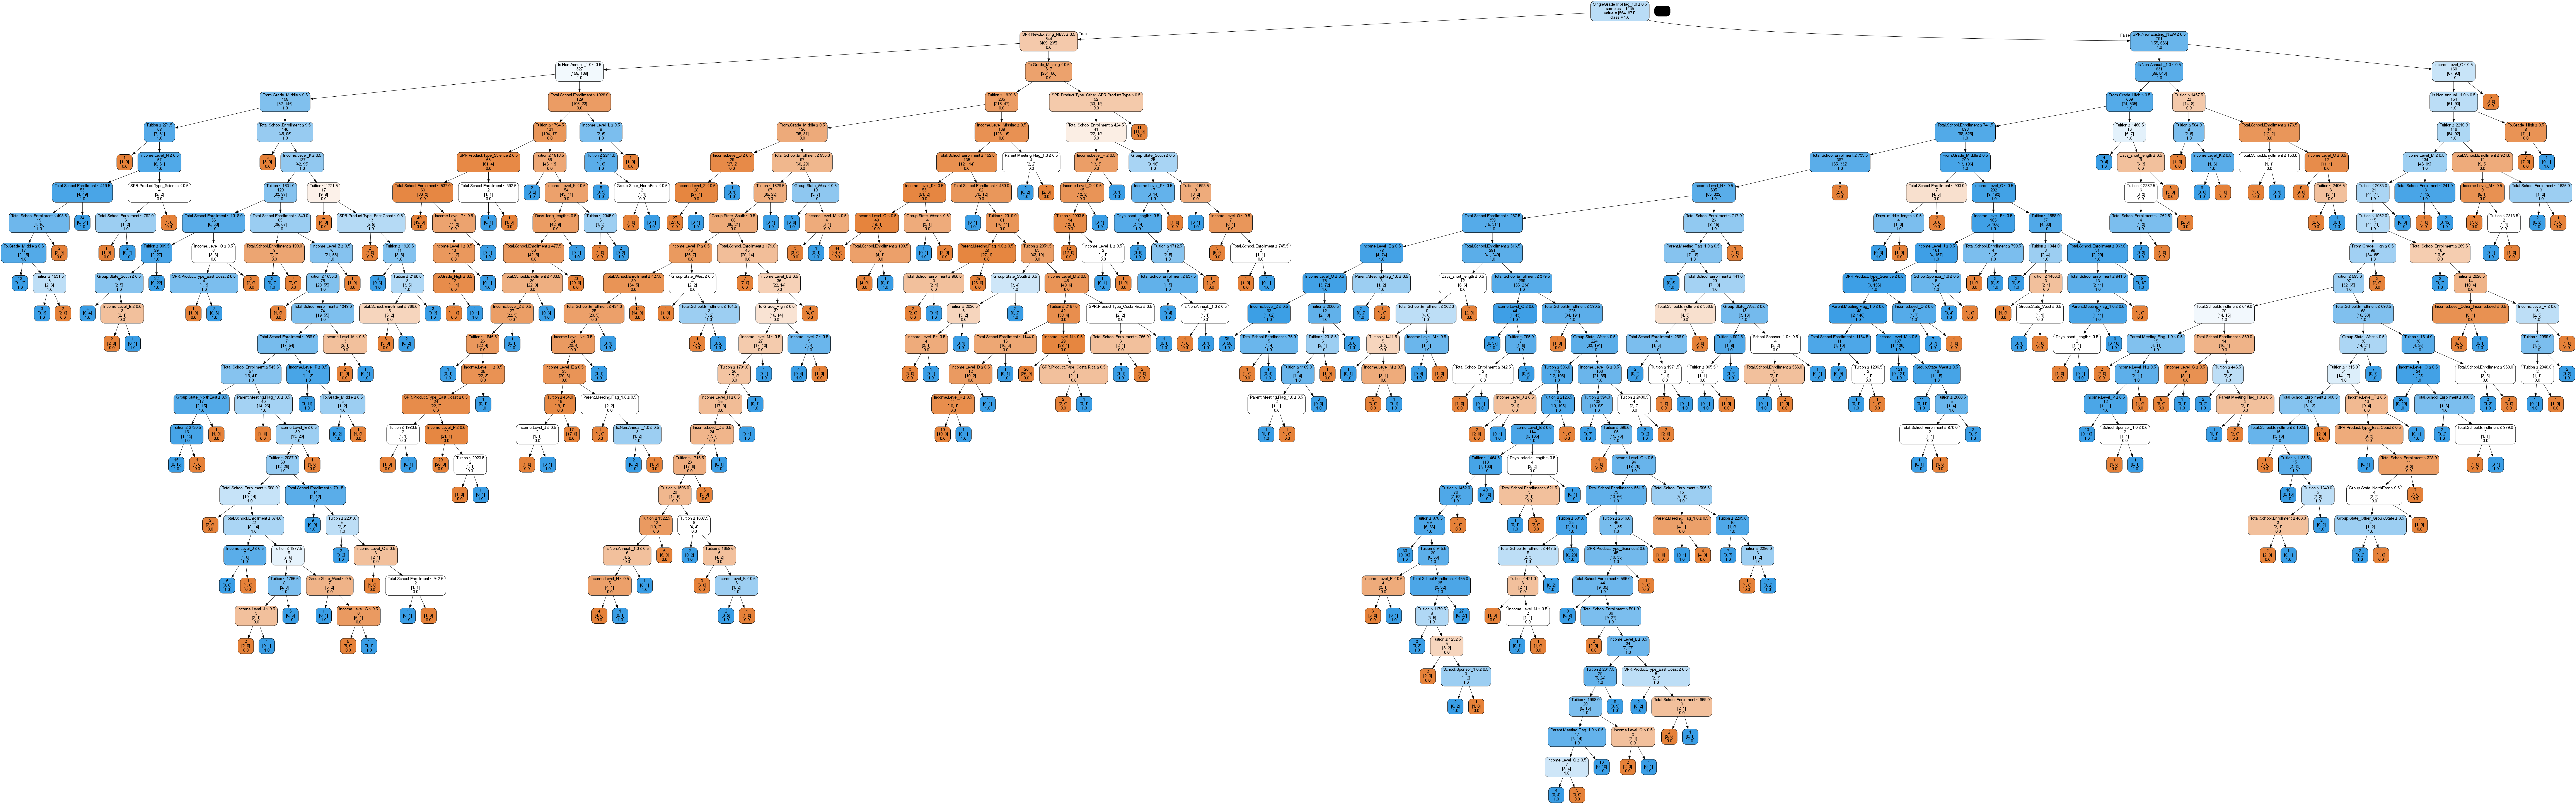

In [366]:
retention_df = pd.get_dummies(retention_df, drop_first=True)

#Separate X and y variables
X = retention_df.drop(columns=['Retained.in.2012.'])
y = retention_df['Retained.in.2012.']

#Partition
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

#Develop trees
retentionClassTree = DecisionTreeClassifier()
retentionClassTree.fit(train_X, train_y)

retentionClassTree.fit(train_X, train_y)

plotDecisionTree(retentionClassTree, feature_names=train_X.columns,class_names=retentionClassTree.classes_)

In [367]:
accuracy_score(valid_y, retentionClassTree.predict(valid_X))

0.7063740856844305

In [368]:
tree_nodes = retentionClassTree.tree_.node_count
print('Number of nodes:', tree_nodes)

Number of nodes: 633


In [369]:
# Grid Search

In [370]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1) #n_jobs=-1 means 
        #that the availalbe computer memory (CPU) will be used to make calculations faster. 
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.7965156794425086
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.005, 'min_samples_split': 20}


In [371]:
# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 20)), 
    'min_samples_split': list(range(50, 90)), 
    'min_impurity_decrease': [0.001, 0.009, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Improved score:  0.802787456445993
Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.001, 'min_samples_split': 50}


In [372]:
accuracy_score(valid_y, bestClassTree.predict(valid_X))

0.7983281086729362

In [373]:
classificationSummary(valid_y, bestClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.7983)

       Prediction
Actual   0   1
     0 255 122
     1  71 509


In [374]:
tree_nodes = bestClassTree.tree_.node_count
print('Number of nodes:', tree_nodes)

Number of nodes: 39


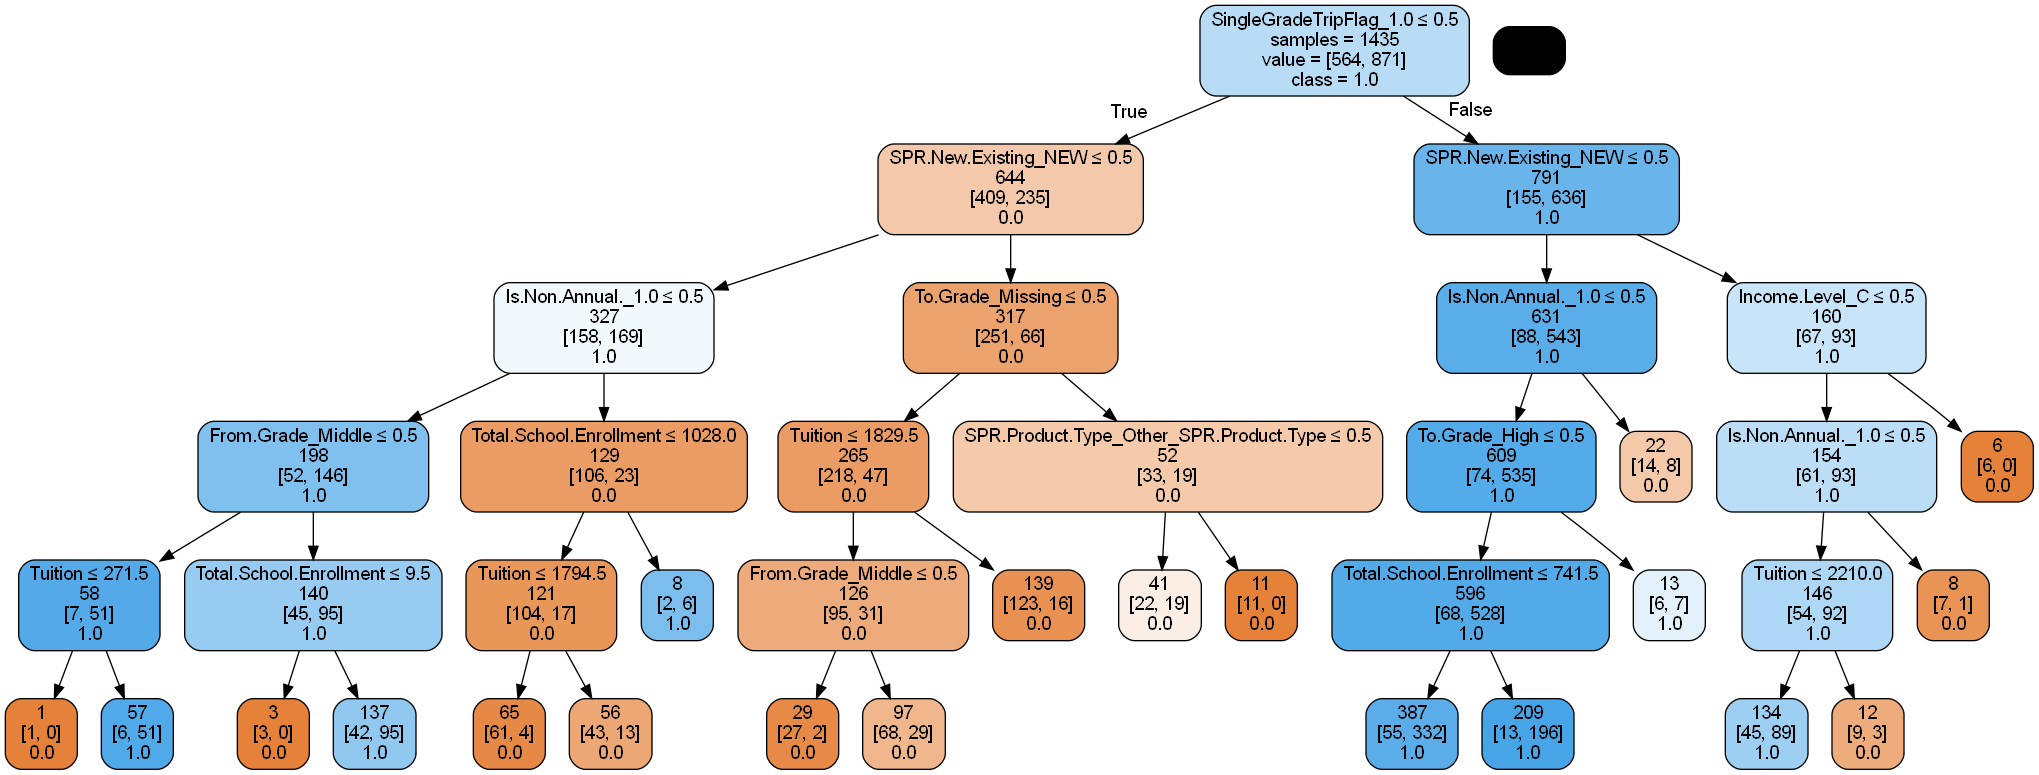

In [375]:
plotDecisionTree(bestClassTree, feature_names=train_X.columns,class_names=bestClassTree.classes_)

In [376]:
# Random Forest

In [377]:
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [378]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

random_forest_df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
random_forest_df = random_forest_df.sort_values('importance')
print(random_forest_df)

ax = random_forest_df.plot(kind='barh', xerr='std', x='feature', legend=False,figsize=(100,100))
ax.set_ylabel('')





plt.show()

                                    feature  importance       std
47  SPR.New.Existing_Other_SPR.New.Existing    0.000000  0.000000
41              SingleGradeTripFlag_Missing    0.000000  0.000000
20                   School.Sponsor_Missing    0.000000  0.000000
18              Parent.Meeting.Flag_Missing    0.000000  0.000000
13                   Is.Non.Annual._Missing    0.000000  0.000000
36          Income.Level_Other_Income.Level    0.001053  0.001311
9             Group.State_Other_Group.State    0.001885  0.002323
14                         Days_long_length    0.002281  0.003363
42              SPR.Product.Type_Costa Rica    0.003497  0.003919
44  SPR.Product.Type_Other_SPR.Product.Type    0.003504  0.005425
23                           Income.Level_D    0.004685  0.003285
21                           Income.Level_B    0.004927  0.003531
4                        From.Grade_Missing    0.005180  0.004787
33                     Income.Level_Missing    0.005199  0.003771
26        

In [379]:
accuracy_score(valid_y, rf.predict(valid_X))

0.7847439916405433

In [380]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.7847)

       Prediction
Actual   0   1
     0 255 122
     1  84 496


In [381]:
# Boosted Tree

In [382]:
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X))

Confusion Matrix (Accuracy 0.7994)

       Prediction
Actual   0   1
     0 260 117
     1  75 505


In [383]:
accuracy_score(valid_y, boost.predict(valid_X))

0.799373040752351

# 2nd classification Tree

In [384]:
#drop from grade and to grade
rentetion_df=df[['Tuition',  'Total.School.Enrollment', 'Group.State','Is.Non.Annual.', 'Days',
  'Parent.Meeting.Flag','School.Sponsor', 'Income.Level', 
       'SingleGradeTripFlag', 'SPR.Product.Type',
       'SPR.New.Existing','Retained.in.2012.']]

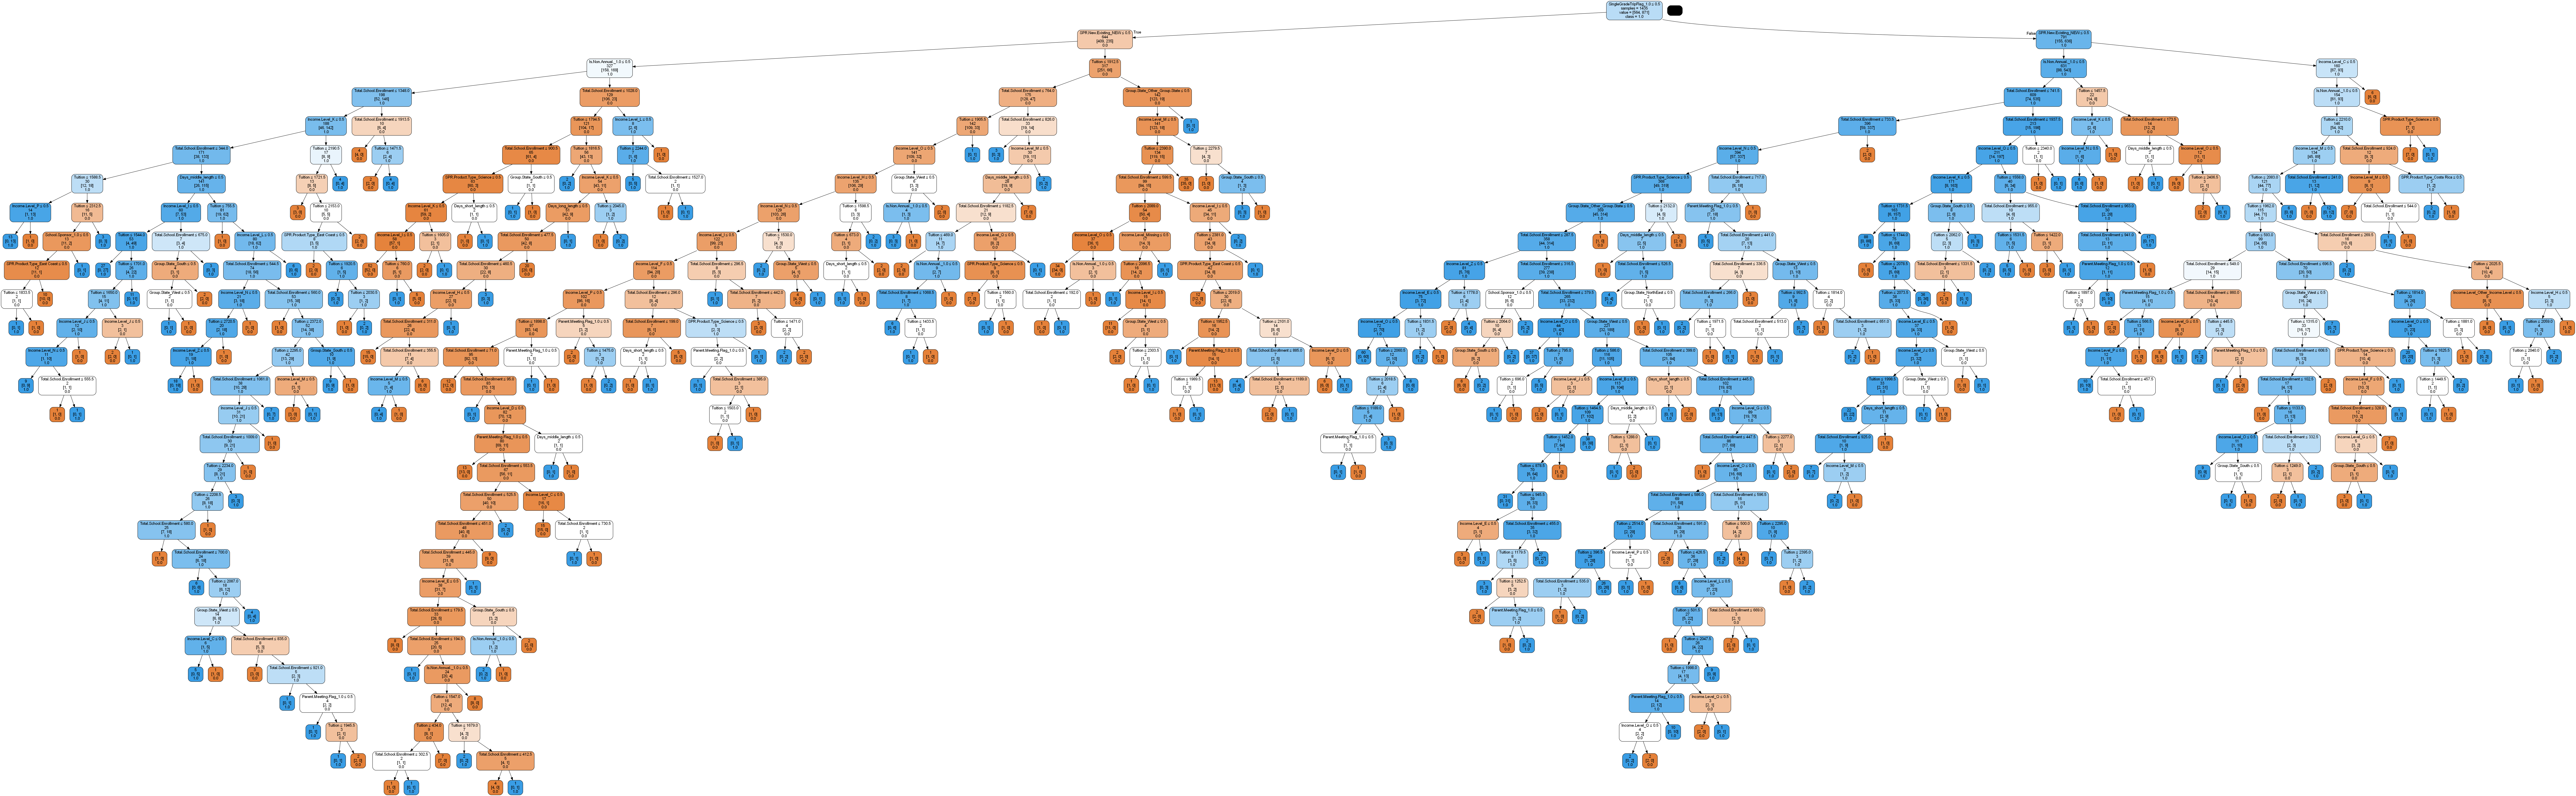

In [385]:
rentetion_df = pd.get_dummies(rentetion_df, drop_first=True)

#Separate X and y variables
X = rentetion_df.drop(columns=['Retained.in.2012.'])
y = rentetion_df['Retained.in.2012.']

#Partition
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

#Develop trees
retentionClassTree = DecisionTreeClassifier()
retentionClassTree.fit(train_X, train_y)

retentionClassTree.fit(train_X, train_y)

plotDecisionTree(retentionClassTree, feature_names=train_X.columns,class_names=retentionClassTree.classes_)

In [386]:
accuracy_score(valid_y, retentionClassTree.predict(valid_X))

0.7021943573667712

In [387]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1) #n_jobs=-1 means 
        #that the availalbe computer memory (CPU) will be used to make calculations faster. 
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.7965156794425086
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.005, 'min_samples_split': 20}


In [388]:
# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 20)), 
    'min_samples_split': list(range(50, 90)), 
    'min_impurity_decrease': [0.001, 0.009, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Improved score:  0.8
Improved parameters:  {'max_depth': 4, 'min_impurity_decrease': 0.001, 'min_samples_split': 53}


In [389]:
accuracy_score(valid_y, bestClassTree.predict(valid_X))

0.7889237199582028

In [390]:
classificationSummary(valid_y, bestClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.7889)

       Prediction
Actual   0   1
     0 250 127
     1  75 505


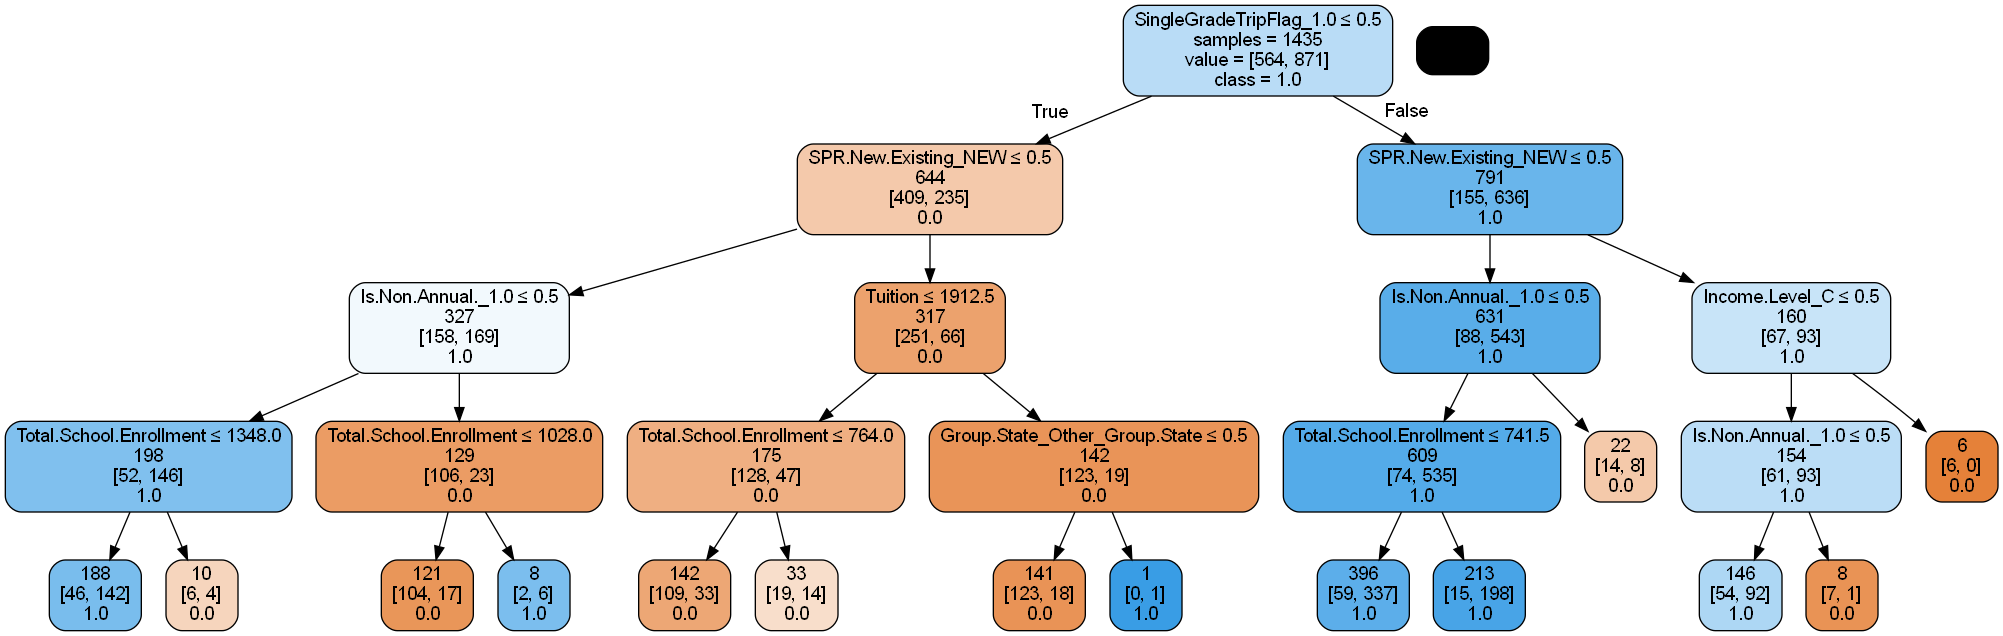

In [391]:
plotDecisionTree(bestClassTree, feature_names=train_X.columns,class_names=bestClassTree.classes_)

In [392]:
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [393]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

random_forest_df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
random_forest_df = random_forest_df.sort_values('importance')
print(random_forest_df)

ax = random_forest_df.plot(kind='barh', xerr='std', x='feature', legend=False,figsize=(100,100))
ax.set_ylabel('')





plt.show()

                                    feature  importance       std
41  SPR.New.Existing_Other_SPR.New.Existing    0.000000  0.000000
35              SingleGradeTripFlag_Missing    0.000000  0.000000
7                    Is.Non.Annual._Missing    0.000000  0.000000
12              Parent.Meeting.Flag_Missing    0.000000  0.000000
14                   School.Sponsor_Missing    0.000000  0.000000
30          Income.Level_Other_Income.Level    0.001197  0.001470
8                          Days_long_length    0.002507  0.003841
3             Group.State_Other_Group.State    0.002560  0.002603
38  SPR.Product.Type_Other_SPR.Product.Type    0.004069  0.006048
27                     Income.Level_Missing    0.004537  0.003389
36              SPR.Product.Type_Costa Rica    0.004633  0.004823
17                           Income.Level_D    0.004722  0.003349
15                           Income.Level_B    0.004985  0.003243
2                     Group.State_NorthEast    0.005587  0.003564
33        

In [394]:
accuracy_score(valid_y, rf.predict(valid_X))

0.7753396029258098

In [395]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.7753)

       Prediction
Actual   0   1
     0 254 123
     1  92 488


In [396]:
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X))

Confusion Matrix (Accuracy 0.7983)

       Prediction
Actual   0   1
     0 261 116
     1  77 503


In [397]:
accuracy_score(valid_y, boost.predict(valid_X))

0.7983281086729362

# Logit Regression

1st Logit Regression with predictors from previous

In [398]:

predictors=['Tuition',  'Total.School.Enrollment','From.Grade', 'To.Grade', 'Group.State','Is.Non.Annual.',
            'Days',
  'Parent.Meeting.Flag','School.Sponsor', 'Income.Level', 
       'SingleGradeTripFlag', 'SPR.Product.Type',
       'SPR.New.Existing']


outcome = 'Retained.in.2012.'

#convert to dummy variables and Separate X and y variables
X = pd.get_dummies(df[predictors], drop_first=True) 
y = df[outcome]

In [399]:
# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)


# fit a logistic regression (set penalty=l2 (a penalty of L2 will force some coefficients to be small, 
#essentially focusing on a fewer variables) and C=1e42 avoids regularization, C denotes how strong we want 
#regularization to be. A smaller C will make regularization stronger )
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

#Get intercepts, coefficients, and AIC
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print() #Creates a Line space
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  0.04916176154346822
        Tuition  Total.School.Enrollment  From.Grade_High  From.Grade_Middle  \
coeff -0.000172                  0.00045        -0.397647           0.347006   

       From.Grade_Missing  To.Grade_High  To.Grade_Middle  To.Grade_Missing  \
coeff            0.349614      -0.174425        -0.056928          0.436649   

       Group.State_NorthEast  Group.State_Other_Group.State  \
coeff              -0.033386                      -0.109181   

       Group.State_South  Group.State_West  Is.Non.Annual._1.0  \
coeff          -0.168067         -0.336556           -2.093617   

       Is.Non.Annual._Missing  Days_long_length  Days_middle_length  \
coeff                     0.0         -0.179017            0.160893   

       Days_short_length  Parent.Meeting.Flag_1.0  \
coeff           0.067287                 0.045494   

       Parent.Meeting.Flag_Missing  School.Sponsor_1.0  \
coeff                          0.0            0.617716   

       School.Sponsor_

In [400]:
# Logit Regression Prediction

In [401]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [555, 1428, 495, 984]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
555      0.0  0.553947  0.446053        0.0
1428     0.0  0.725030  0.274970        0.0
495      0.0  0.493824  0.506176        1.0
984      0.0  0.974178  0.025822        0.0


In [402]:
#Use the classification summary function for training data
classificationSummary(train_y, logit_reg.predict(train_X))

Confusion Matrix (Accuracy 0.8056)

       Prediction
Actual   0   1
     0 390 174
     1 105 766


In [403]:
#Use the classification summary function for validation data
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.7941)

       Prediction
Actual   0   1
     0 260 117
     1  80 500


In [404]:
accuracy_score(valid_y, logit_reg.predict(valid_X))

0.7941483803552769

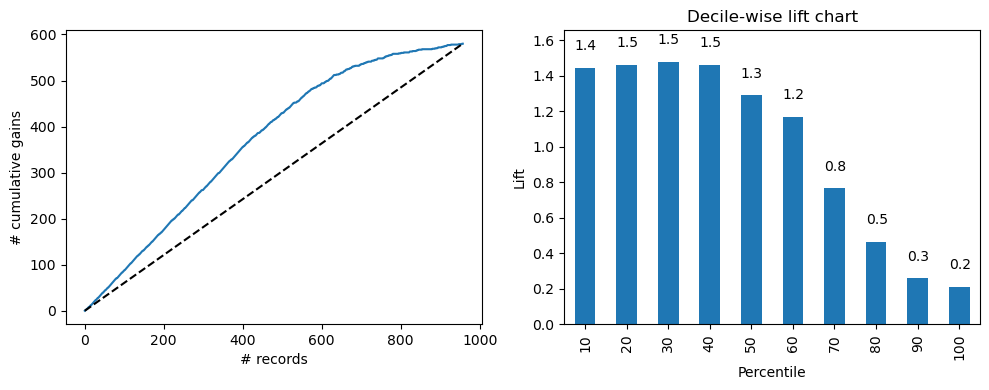

In [405]:
logit_df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(logit_df.actual, ax=axes[0])
liftChart(logit_df.actual, title='Decile-wise lift chart', ax=axes[1])
    
plt.tight_layout()
plt.show()

2nd Logit Regression Model with all predictors

In [406]:
predictors = ['From.Grade', 'To.Grade', 'Group.State',
       'Is.Non.Annual.', 'Days', 'Travel.Type', 'Departure.Date',
       'Return.Date', 'Deposit.Date', 'Special.Pay', 'Tuition', 
        'Initial.System.Date',
       'Poverty.Code', 'Region', 'CRM.Segment', 'School.Type',
       'Parent.Meeting.Flag', 'MDR.Low.Grade', 'MDR.High.Grade',
       'Total.School.Enrollment', 'Income.Level', 
       'School.Sponsor', 'SPR.Product.Type', 'SPR.New.Existing',
        'NumberOfMeetingswithParents',
       'FirstMeeting', 'LastMeeting', 'DifferenceTraveltoFirstMeeting',
       'DifferenceTraveltoLastMeeting', 'SchoolGradeTypeLow',
       'SchoolGradeTypeHigh', 'SchoolGradeType', 'DepartureMonth',
       'GroupGradeTypeLow', 'GroupGradeTypeHigh', 'GroupGradeType',
       'MajorProgramCode', 'SingleGradeTripFlag',  'SchoolSizeIndicator',]
outcome = 'Retained.in.2012.'


In [407]:
#convert to dummy variables and Separate X and y variables
X1 = pd.get_dummies(df[predictors], drop_first=True)
y1 = df[outcome]


In [408]:
# partition data
train_X1, valid_X1, train_y1, valid_y1 = train_test_split(X1, y1, test_size=0.4, random_state=1)


# fit a logistic regression (set penalty=l2 (a penalty of L2 will force some coefficients to be small, 
#essentially focusing on a fewer variables) and C=1e42 avoids regularization, C denotes how strong we want 
#regularization to be. A smaller C will make regularization stronger )
logit_reg1 = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg1.fit(train_X1, train_y1)

#Get intercepts, coefficients, and AIC
print('intercept ', logit_reg1.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg1.coef_[0]}, index=X1.columns).transpose())
print() #Creates a Line space
print('AIC', AIC_score(valid_y1, logit_reg1.predict(valid_X1), df = len(train_X1.columns) + 1))

intercept  0.31968819276926075
            Tuition  Total.School.Enrollment  NumberOfMeetingswithParents  \
coeff -1.436610e-07                 0.000375                     0.418375   

       DifferenceTraveltoFirstMeeting  DifferenceTraveltoLastMeeting  \
coeff                       -0.002153                       0.004835   

       From.Grade_High  From.Grade_Middle  From.Grade_Missing  To.Grade_High  \
coeff         0.025229           0.246536            0.030455      -0.181612   

       To.Grade_Middle  To.Grade_Missing  Group.State_NorthEast  \
coeff         0.177112          0.420383              -0.273922   

       Group.State_Other_Group.State  Group.State_South  Group.State_West  \
coeff                      -1.625712          -0.401906         -1.056895   

       Is.Non.Annual._1.0  Is.Non.Annual._Missing  Days_long_length  \
coeff           -2.977791                     0.0         -1.084413   

       Days_middle_length  Days_short_length  Travel.Type_B  \
coeff       

In [409]:
#Logit Regression Predict

In [410]:
logit_reg_pred = logit_reg1.predict(valid_X1)
logit_reg_proba = logit_reg1.predict_proba(valid_X1)
logit_result = pd.DataFrame({'actual': valid_y1, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [1375, 335, 2329, 1773]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
1375     1.0  0.040449  0.959551        1.0
335      0.0  0.676512  0.323488        0.0
2329     0.0  0.310676  0.689324        1.0
1773     0.0  0.986065  0.013935        0.0


In [411]:
#Use the classification summary function for training data
classificationSummary(train_y1, logit_reg1.predict(train_X1))

Confusion Matrix (Accuracy 0.8676)

       Prediction
Actual   0   1
     0 453 111
     1  79 792


In [412]:
#Use the classification summary function for validation data
classificationSummary(valid_y1, logit_reg1.predict(valid_X1))

Confusion Matrix (Accuracy 0.7429)

       Prediction
Actual   0   1
     0 244 133
     1 113 467


Gains chart and Decile-wise lift chart

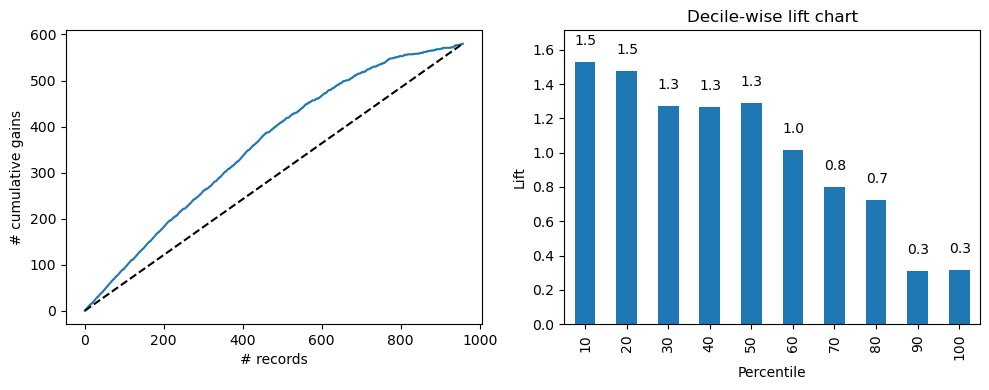

In [413]:
logit_df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(logit_df.actual, ax=axes[0])
liftChart(logit_df.actual, title='Decile-wise lift chart', ax=axes[1])
    
plt.tight_layout()
plt.show()

# New Record Prediction w/ Logit Regression

In [414]:
df['Travel.Type'].unique()

array(['A', 'B', 'Other_Travel.Type'], dtype=object)

In [415]:
predictors=['Tuition',  'Total.School.Enrollment','From.Grade', 'To.Grade', 'Group.State','Is.Non.Annual.',
            'Days',
  'Parent.Meeting.Flag','School.Sponsor', 'Income.Level', 
       'SingleGradeTripFlag', 'SPR.Product.Type',
       'SPR.New.Existing']

In [416]:
newdata=pd.DataFrame([{'Tuition':500, 'Total.School.Enrollment':2000, 'From.Grade_High':0,
       'From.Grade_Middle':1, 'From.Grade_Missing':0, 'To.Grade_High':0,
       'To.Grade_Middle':1, 'To.Grade_Missing':0, 'Group.State_NorthEast':1,
       'Group.State_Other_Group.State':0, 'Group.State_South':0,
       'Group.State_West':0, 'Is.Non.Annual._1.0':0, 'Is.Non.Annual._Missing':0,
       'Days_long_length':0, 'Days_middle_length':1, 'Days_short_length':0,
       'Parent.Meeting.Flag_1.0':1, 'Parent.Meeting.Flag_Missing':0,
       'School.Sponsor_1.0':1, 'School.Sponsor_Missing':0, 'Income.Level_B':0,
       'Income.Level_C':0, 'Income.Level_D':0, 'Income.Level_E':0, 'Income.Level_F':0,
       'Income.Level_G':0, 'Income.Level_H':1, 'Income.Level_I':0, 'Income.Level_J':0,
       'Income.Level_K':0, 'Income.Level_L':0, 'Income.Level_M':0,
       'Income.Level_Missing':0, 'Income.Level_N':0, 'Income.Level_O':0,
       'Income.Level_Other_Income.Level':0, 'Income.Level_P':0, 'Income.Level_Q':0,
       'Income.Level_Z':0, 'SingleGradeTripFlag_1.0':1,
       'SingleGradeTripFlag_Missing':0, 'SPR.Product.Type_Costa Rica':0,
       'SPR.Product.Type_East Coast':1,
       'SPR.Product.Type_Other_SPR.Product.Type':0, 'SPR.Product.Type_Science':0,
       'SPR.New.Existing_NEW':0, 'SPR.New.Existing_Other_SPR.New.Existing':0}])
newdata

Tuition  Total.School.Enrollment  From.Grade_High  From.Grade_Middle  \
0      500                     2000                0                  1   

   From.Grade_Missing  To.Grade_High  To.Grade_Middle  To.Grade_Missing  \
0                   0              0                1                 0   

   Group.State_NorthEast  Group.State_Other_Group.State  Group.State_South  \
0                      1                              0                  0   

   Group.State_West  Is.Non.Annual._1.0  Is.Non.Annual._Missing  \
0                 0                   0                       0   

   Days_long_length  Days_middle_length  Days_short_length  \
0                 0                   1                  0   

   Parent.Meeting.Flag_1.0  Parent.Meeting.Flag_Missing  School.Sponsor_1.0  \
0                        1                            0                   1   

   School.Sponsor_Missing  Income.Level_B  Income.Level_C  Income.Level_D  \
0                       0               0               0               0   

   Income.Level_E  Income.Level_F  Income.Level_G  Income.Level_H  \
0               0               0               0               1   

   Income.Level_I  Income.Level_J  Income.Level_K  Income.Level_L  \
0               0               0               0               0   

   Income.Level_M  Income.Level_Missing  Income.Level_N  Income.Level_O  \
0               0                     0               0               0   

   Income.Level_Other_Income.Level  Income.Level_P  Income.Level_Q  \
0                                0               0               0   

   Income.Level_Z  SingleGradeTripFlag_1.0  SingleGradeTripFlag_Missing  \
0               0                        1                            0   

   SPR.Product.Type_Costa Rica  SPR.Product.Type_East Coast  \
0                            0                            1   

   SPR.Product.Type_Other_SPR.Product.Type  SPR.Product.Type_Science  \
0                                        0                         0   

   SPR.New.Existing_NEW  SPR.New.Existing_Other_SPR.New.Existing  
0                     0                                        0

In [417]:
logit_reg_pred = logit_reg.predict(newdata)
logit_reg_proba = logit_reg.predict_proba(newdata)
logit_result = pd.DataFrame({
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })


print(logit_result)

       p(0)      p(1)  predicted
0  0.025694  0.974306        1.0
